In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from altaipony.flarelc import FlareLightCurve

flux_label = r"Flux [e$^{-}$/s]"
time_label = "Time [BJD]"

# load all the file names
files = np.loadtxt("data/cheops_files.txt", dtype=str)

files

array([['i', '101'],
       ['i', '102'],
       ['i', '103'],
       ['i', '104'],
       ['i', '105'],
       ['i', '106'],
       ['i', '107'],
       ['i', '108'],
       ['i', '109'],
       ['i', '110'],
       ['i', '111'],
       ['ch', '101'],
       ['ch', '102'],
       ['ch', '103'],
       ['ch', '104'],
       ['ch', '501'],
       ['ch', '601'],
       ['ch', '701'],
       ['ch', '801'],
       ['ch', '901'],
       ['ch', '1001']], dtype='<U4')

In [3]:
# GET THE DATA ---------------------------------------------------------------

# pick a file
file = files[-3]

folder = "results/cheops/"

# load the detrended data
location = f"{folder}HIP67522_{file[1]}{file[0]}_detrended_lc.csv"
df = pd.read_csv(location)

# plt.scatter(df.time, df.flux)

# use flag==0 to mask the big flare
df = df[df.flag == 0]

# plt.scatter(df.time, df.flux, c="r")


# FIND FLARES WITH ALTAIPONY ----------------------------------------------------

# define flare light curve
flc = FlareLightCurve(time = df.time, flux = df.flux, flux_err=np.std(df.flux))
flc.detrended_flux = df.flux
flc.detrended_flux_err = np.std(df.flux)

# find flares
flares = flc.find_flares(N1=2, N2=2, N3=2).flares


Found 2 candidate(s) in the (0,3387) gap.
/home/ilin/anaconda3/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


0
1895


IndexError: index 0 is out of bounds for axis 0 with size 0

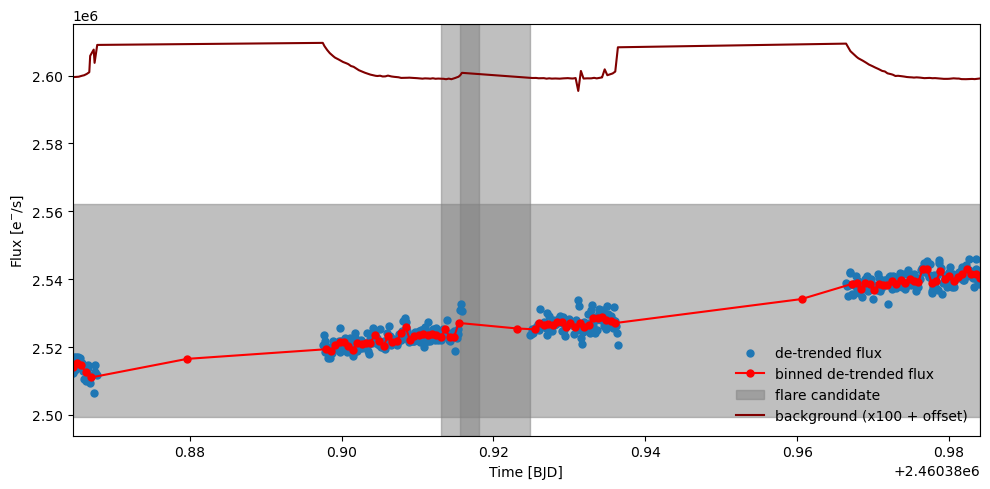

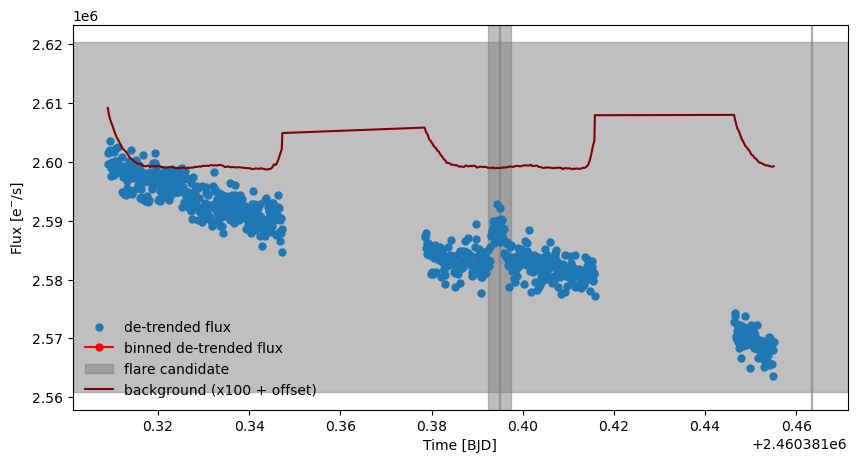

In [4]:
%matplotlib inline
# PLOT THE FLARE CANDIDATES ----------------------------------------------------------
for i, row in flares.iterrows():

    plt.figure(figsize=(10, 5))
      
    # how much to show around the flare
    window = 0.06

    # flare mask
    flare_m = (df.time > (row.tstart - window - 0.05)) & (df.time < (row.tstop + window ))

    print(np.where(flare_m)[0][0])

    # apply the mask
    tflare = df.time[flare_m].values
    fflare = df.masked_raw_flux[flare_m].values
    bgflare = df.bg[flare_m].values

    std = np.std(fflare)
    mean = np.median(fflare)

    # calculate factor to scale the background
    rangetflare = np.max(fflare) - np.min(fflare)

    # scale the background
    bgflare = bgflare*1000 + np.median(df.flux)#(bgflare - np.median(bgflare))*rangetflare/10 + np.median(df.flux) + rangetflare

    # plot the data
    plt.plot(tflare, fflare, ".", markersize=10, label="de-trended flux")

    # now bin the data to show in overlay
    binsize = 5

    index = tflare.shape[0] % binsize

    # drop the last few data points
    t1 = tflare[:-index]
    f1 = fflare[:-index]

    # bin the data
    binned_t = np.mean(t1.reshape(-1, binsize), axis=1)
    binned_f = np.mean(f1.reshape(-1, binsize), axis=1)

    # plot the binned data
    plt.plot(binned_t, binned_f, ".-", markersize=10, color="red", label="binned de-trended flux")

    # shade the region of the flare
    plt.axvspan(row.tstart-0.0025, row.tstart+0.0025, alpha=0.5, color="grey")#, label="flare candidate")
    plt.axvspan(row.tstart+98.6/60/24, row.tstop+98.6/60/24, alpha=0.5, color="grey")#, label="flare candidate")
    plt.axvspan(row.tstart, row.tstop, alpha=0.5, color="grey", label="flare candidate")

    plt.axhspan(mean - 3* std, mean + 4*std, alpha=0.5, color="grey")
    
    plt.plot(tflare, bgflare, color="maroon", label="background (x100 + offset)")

    # layout
    plt.xlabel(time_label)
    plt.ylabel(flux_label)
    plt.legend(frameon=False)
    plt.xlim(binned_t[0], binned_t[-1])
    plt.tight_layout()
    # plt.savefig(f"../plots/paper/false_positive_flare_{file[1]}{file[0]}_{i}.png")

In [22]:
from astropy.io import fits
hdu = fits.open("../data/hip67522/raw_data/CHEOPS-products-visit_801/CH_PR240017_TG000801_TU2024-03-11T08-38-32_SCI_RAW_Imagette_V0300.fits")

In [50]:
hdu[1].data[66]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

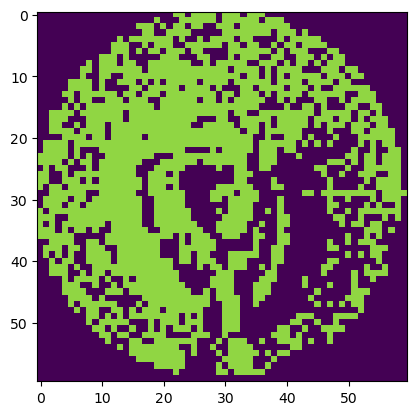

In [71]:
# plt.imshow(hdu[1].data[1129],  cmap="viridis")
i1, i2 = 1129, 2198
vmin = np.min(hdu[1].data[i1] - hdu[1].data[i2])
vmax = np.max(hdu[1].data[i1] - hdu[1].data[i2])
plt.imshow(hdu[1].data[i1] - hdu[1].data[i2],  cmap="viridis", vmin=vmin*0.8, vmax=vmax*1.2)

In [109]:
0.005*24*60

7.199999999999999